In [12]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objs as go  # Import plotly graph objects
import pandas as pd
from dynamic_pricing.db.db_utils import get_db_connection, load_order_data

In [13]:
conn = get_db_connection()

df: pd.DataFrame = load_order_data(conn, "nostimo")
print(df.columns)
df.head()

2024-03-03 18:44:32,622 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-03-03 18:44:32,624 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-03 18:44:32,828 INFO sqlalchemy.engine.Engine select current_schema()
2024-03-03 18:44:32,830 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-03 18:44:33,033 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-03-03 18:44:33,034 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-03 18:44:33,954 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-03-03 18:44:33,956 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

,order_id,deliveroo_order_id,deliveroo_order_number,order_status,order_placed_timestamp,order_updated_timestamp,order_prepare_for_timestamp,order_start_prepping_at_timestamp,customer_id,first_name,...,item_name,item_operational_name,item_quantity,item_fractional_price,modifier_id,deliveroo_modifier_id,modifier_name,modifier_operational_name,modifier_quantity,modifier_fractional_price
0,2,gb:b6aa96ce-896d-4367-8fd7-a33afcce71de,1846977959,accepted,2023-06-26 16:04:36,2023-06-26 16:04:52,2023-06-26 16:23:14,2023-06-26 16:04:45,None,None,...,Chicken Skewer Wrap,Chicken Skewer Wrap (Handmade Greek Pitta Wraps),1,850,None,None,None,None,None,None
1,2,gb:b6aa96ce-896d-4367-8fd7-a33afcce71de,1846977959,accepted,2023-06-26 16:04:36,2023-06-26 16:04:52,2023-06-26 16:23:14,2023-06-26 16:04:45,None,None,...,Chicken Gyros Wrap,Chicken Gyros Wrap (Handmade Greek Pitta Wraps),1,850,None,None,None,None,None,None
2,2,gb:b6aa96ce-896d-4367-8fd7-a33afcce71de,1846977959,accepted,2023-06-26 16:04:36,2023-06-26 16:04:52,2023-06-26 16:23:14,2023-06-26 16:04:45,None,None,...,Pork Skewers Wrap,Pork Skewers Wrap (Handmade Greek Pitta Wraps),1,850,None,None,None,None,None,None
3,4,gb:2448923a-6bd3-4100-9f06-033bb09a8456,1847204847,accepted,2023-06-26 17:42:24,2023-06-26 17:43:58,2023-06-26 18:02:36,2023-06-26 17:43:53,None,None,...,Coca Cola Zero,Coca Cola Zero (Soft Drinks),1,280,None,None,None,None,None,None
4,4,gb:2448923a-6bd3-4100-9f06-033bb09a8456,1847204847,accepted,2023-06-26 17:42:24,2023-06-26 17:43:58,2023-06-26 18:02:36,2023-06-26 17:43:53,None,None,...,Greek Salad,Greek Salad (Starters and Sharers),1,1050,None,None,None,None,None,None


In [21]:
# pre_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
# pre_dp_df = pre_dp_df[
#     (pre_dp_df["order_placed_timestamp"] >= "2023-06-26")
#     & (pre_dp_df["order_placed_timestamp"] < "2023-08-13")
# ]
# pre_dp_df.info()


# post_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
# post_dp_df = post_dp_df[
#     (post_dp_df["order_placed_timestamp"] >= "2023-08-28")
#     & (post_dp_df["order_placed_timestamp"] < "2023-10-09")
# ]
# post_dp_df.info()

pre_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
pre_dp_df = pre_dp_df[
    (pre_dp_df["order_placed_timestamp"] >= "2023-06-26")
    & (pre_dp_df["order_placed_timestamp"] < "2023-7-17")
]
pre_dp_df.info()

pre_dp_df.to_csv("pre_dp_df.csv")


post_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
post_dp_df = post_dp_df[
    (post_dp_df["order_placed_timestamp"] >= "2023-7-17")
    & (post_dp_df["order_placed_timestamp"] < "2023-8-07")
]
post_dp_df.info()

interval = 5

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 0 to 234
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           64 non-null     int64         
 1   deliveroo_order_id                 64 non-null     object        
 2   deliveroo_order_number             64 non-null     int64         
 3   order_status                       64 non-null     object        
 4   order_placed_timestamp             64 non-null     datetime64[ns]
 5   order_updated_timestamp            64 non-null     datetime64[ns]
 6   order_prepare_for_timestamp        64 non-null     datetime64[ns]
 7   order_start_prepping_at_timestamp  64 non-null     datetime64[ns]
 8   customer_id                        0 non-null      object        
 9   first_name                         0 non-null      object        
 10  contact_number                     0 non-nul

In [22]:
def revenue_by_order(df: pd.DataFrame) -> pd.DataFrame:
    df = df[
        [
            "order_id",
            "item_quantity",
            "item_fractional_price",
            "modifier_fractional_price",
            "modifier_quantity",
            "order_placed_timestamp",
        ]
    ].copy()
    df.fillna(0, inplace=True)

    df["order_value"] = (
        (df["item_fractional_price"] * df["item_quantity"])
        + (df["modifier_fractional_price"] * df["modifier_quantity"])
    ) / 100
    df["revenue"] = df.groupby("order_id")["order_value"].sum()
    df["ds"] = pd.to_datetime(df["order_placed_timestamp"])
    df["y"] = df["revenue"]
    df = df[["ds", "y"]].copy()
    return df


def forecast(df: pd.DataFrame,forecast_interval) -> pd.DataFrame:
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=forecast_interval)
    return m, m.predict(future)


64 55


/tmp/ipykernel_407435/3303689866.py:12: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_407435/3303689866.py:12: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



<Axes: xlabel='ds'>

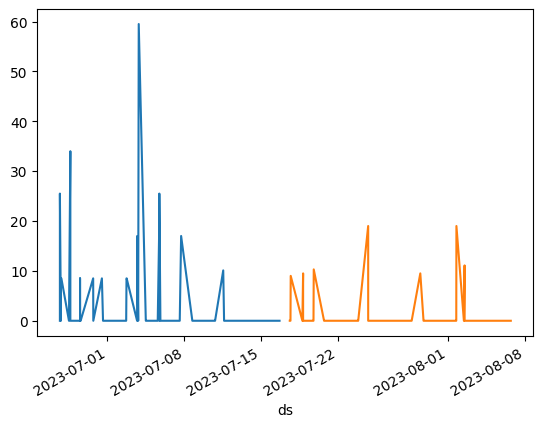

In [26]:
rev_pre_dp_df = revenue_by_order(pre_dp_df)
rev_post_dp_df = revenue_by_order(post_dp_df)


pre_dp_series = rev_pre_dp_df.set_index("ds")["y"].fillna(0)
post_dp_series = rev_post_dp_df.set_index("ds")["y"].fillna(0)

print(len(pre_dp_series),len(post_dp_series))
pre_dp_series.plot()
post_dp_series.plot()

In [27]:
m1, forecast1 = forecast(revenue_by_order(pre_dp_df), 5)
m2, forecast2 = forecast(revenue_by_order(post_dp_df), 5)
fig1 = plot_plotly(m1, forecast1)
fig2 = plot_plotly(m2, forecast2)


fig1.show()
fig2.show()

/tmp/ipykernel_407435/3303689866.py:12: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



TypeError: 'DataFrame' object is not callable

In [ ]:
m, forecast = forecast(revenue_by_order(df), 5)
fig = plot_plotly(m, forecast)
fig.show()
plot_components_plotly(m, forecast).show()

/tmp/ipykernel_407435/3303689866.py:12: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
